In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")


In [3]:
forest_fires_count_cities = pd.read_csv("forest_fires_count_cities.csv")
turkey_climate = pd.read_csv("turkey_climate.csv")
turkey_fires = pd.read_csv("turkey-fires-with-cities.csv")


In [4]:
turkey_climate = turkey_climate.drop('Latitude', axis = 1)
turkey_climate = turkey_climate.drop('Longitude', axis = 1)
turkey_climate = turkey_climate.dropna()
turkey_climate['Year'] = turkey_climate.apply(lambda row: int(row['dt'].split('-')[0]), axis=1)
turkey_climate['Month'] = turkey_climate.apply(lambda row: int(row['dt'].split('-')[1]), axis=1)
turkey_climate = turkey_climate.drop('AverageTemperatureUncertainty', axis = 1)
turkey_climate = turkey_climate.reset_index(drop = True)
turkey_climate.head()

,dt,AverageTemperature,City,Year,Month
0,1743-11-01,10.013,Çorlu,1743,11
1,1744-04-01,13.685,Çorlu,1744,4
2,1744-05-01,15.021,Çorlu,1744,5
3,1744-06-01,19.663,Çorlu,1744,6
4,1744-07-01,22.314,Çorlu,1744,7


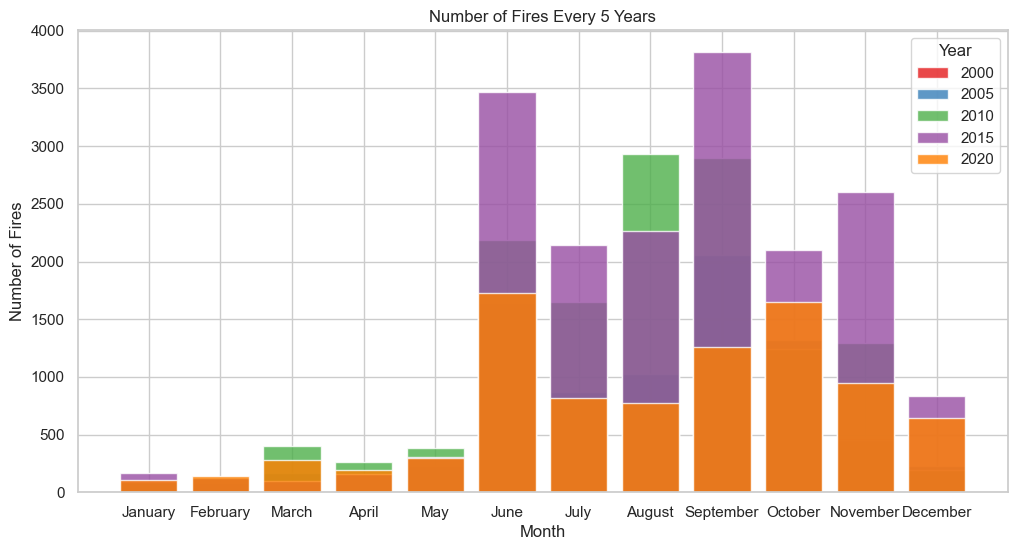

In [5]:
plt.figure(figsize=(12, 6))


sns.set_theme(style="whitegrid")

firesby5years = forest_fires_count_cities.groupby(['Year', 'Month'])['count'].sum().reset_index()


years = sorted(firesby5years['Year'].unique())[::5]


sns.set_palette("Set1", n_colors=len(years))


for year in years:
    data = firesby5years[firesby5years['Year'] == year]
    plt.bar(data['Month'], data['count'], label=year, alpha=0.8)


plt.xlabel('Month')
plt.ylabel('Number of Fires')
plt.title('Number of Fires Every 5 Years')


month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.xticks(ticks=[i for i in range(1,13)], labels=month_names)


plt.legend(title='Year', bbox_to_anchor=(1, 1), labels=years)

plt.show()


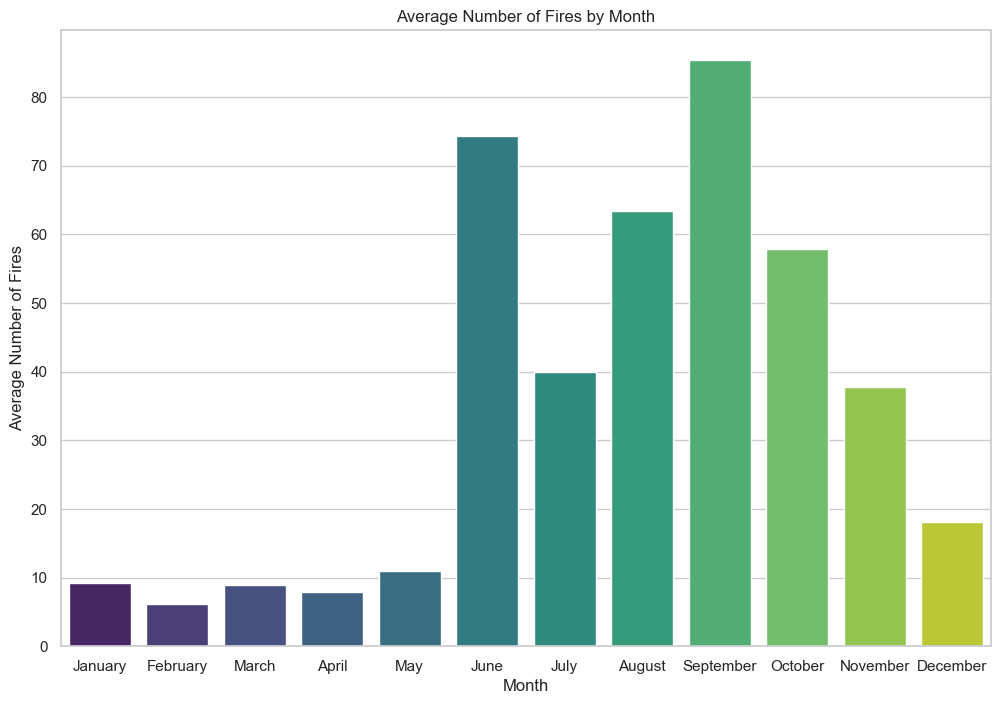

In [6]:
monthly_fire_avg = forest_fires_count_cities.groupby('Month')['count'].mean().reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='Month', y='count', data=monthly_fire_avg, palette='viridis')
plt.title('Average Number of Fires by Month')
plt.xlabel('Month')
plt.ylabel('Average Number of Fires')
plt.xticks(ticks=[i for i in range(12)], labels=month_names)
plt.show()

In [7]:
yearly_mean_turkey = turkey_climate.copy()
yearly_mean_turkey['Date'] = pd.to_datetime(yearly_mean_turkey[['Year', 'Month']].assign(DAY=1))
yearly_mean_turkey = yearly_mean_turkey.groupby(yearly_mean_turkey['Date'].dt.year)['AverageTemperature'].mean().reset_index()
yearly_mean_turkey.columns = ['Year', 'YearlyMeanTemperature']
yearly_mean_turkey = yearly_mean_turkey[yearly_mean_turkey['Year'] > 1755]


fig = px.line(yearly_mean_turkey, x='Year', y='YearlyMeanTemperature', 
              labels={'YearlyMeanTemperature': 'Average Temperature', 'Year': 'Year'},
              title='Average Annual Temperature Change')
fig.show()

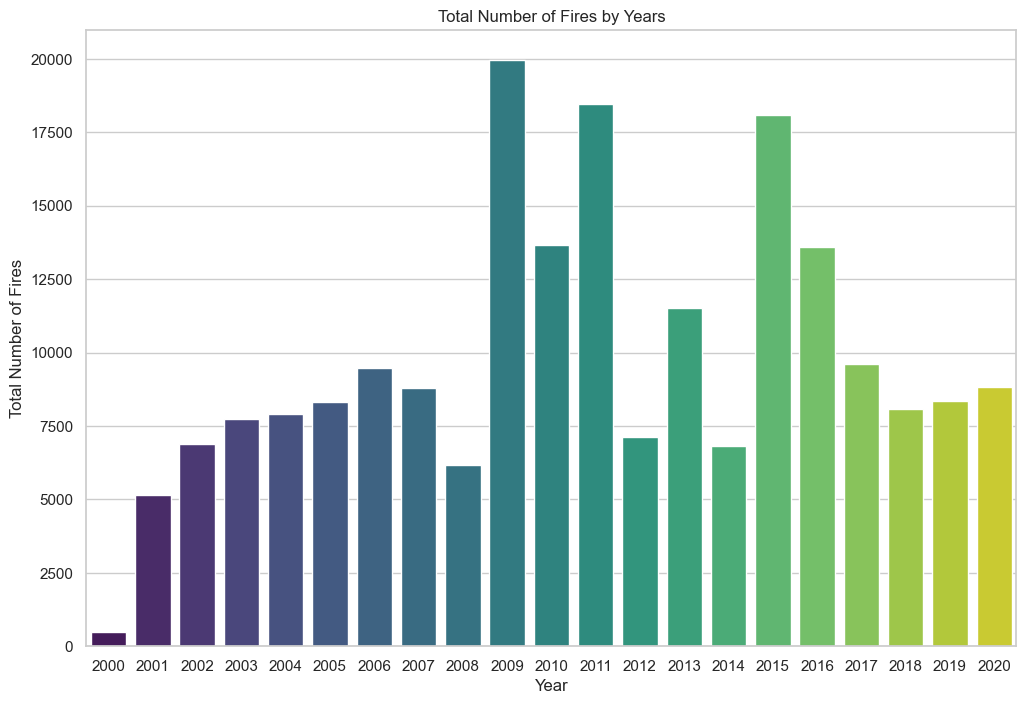

In [8]:
yearly_fire_count = forest_fires_count_cities.groupby('Year')['count'].sum().reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='Year', y='count', data=yearly_fire_count, palette='viridis')
plt.title('Total Number of Fires by Years')
plt.xlabel('Year')
plt.ylabel('Total Number of Fires')
plt.show()

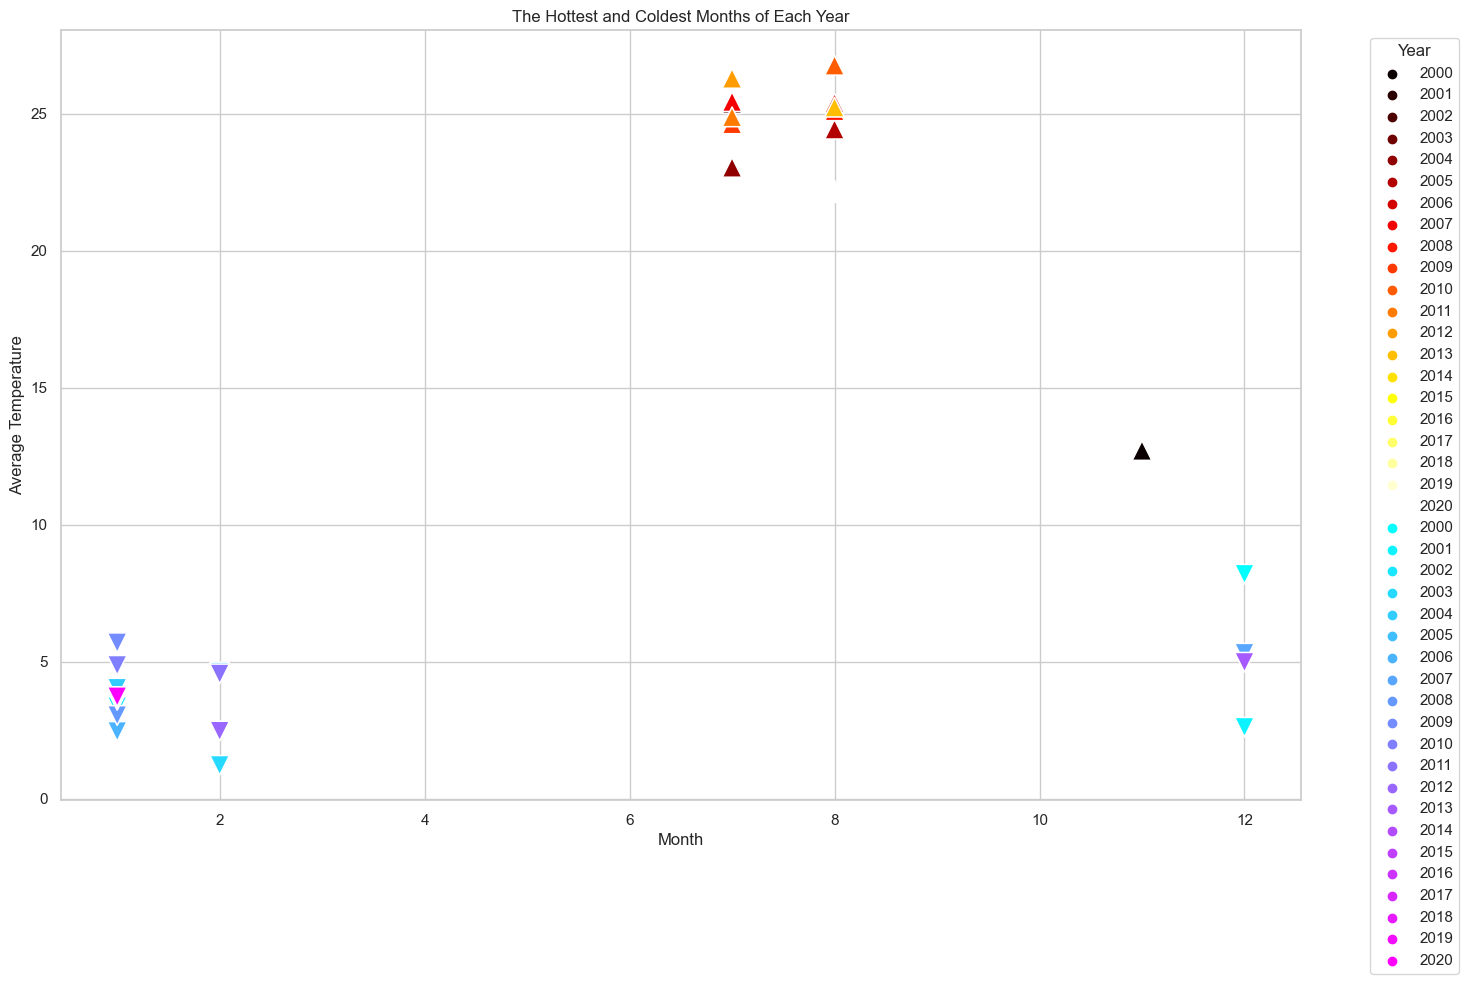

In [9]:
hottest_months = forest_fires_count_cities.loc[forest_fires_count_cities.groupby('Year')['AverageTemperature'].idxmax()]
coldest_months = forest_fires_count_cities.loc[forest_fires_count_cities.groupby('Year')['AverageTemperature'].idxmin()]

# Nokta grafiği çizimi
plt.figure(figsize=(16, 10))
sns.scatterplot(x='Month', y='AverageTemperature', hue='Year', data=hottest_months, marker='^', s=200, palette='hot', legend='full')
sns.scatterplot(x='Month', y='AverageTemperature', hue='Year', data=coldest_months, marker='v', s=200, palette='cool', legend='full')

plt.title('The Hottest and Coldest Months of Each Year')
plt.xlabel('Month')
plt.ylabel('Average Temperature')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [10]:
unique_cities = turkey_climate['City'].unique()

city_dfs = {}

for city in unique_cities:
    city_df = turkey_climate[turkey_climate['City'] == city]
    city_df = city_df.drop('City',axis = 1)
    city_dfs[city] = city_df


In [11]:
def create_monthly_dict(df):
    temperature_dict = {}

    for month in range(1, 13):
        month_data = pd.DataFrame(df[df['Month'] == month][['Year', 'AverageTemperature']].to_dict(orient='records'))
        temperature_dict[month] = month_data

    return temperature_dict

cities_montly_dict = {}

for i in unique_cities:
    cities_montly_dict[i] = create_monthly_dict(city_dfs[i])




In [12]:
def create_monthly_model(df, city, month):
    months = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 
              7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}
    

    df = df[city][month]
    year = np.array(df['Year'])
    temperature = np.array(df['AverageTemperature'])


    degree = 3
    coefficients = np.polyfit(year, temperature, degree)

    poly_function = np.poly1d(coefficients)

    fitted_values = np.array(poly_function(year))

    plt.scatter(year, temperature, label='Actual Data', color='blue')
    plt.plot(year, fitted_values, label=f'Polynomial Regression (Degree {degree})', color='red')
    plt.xlabel('Year')
    plt.ylabel('Average Temperature')
    plt.title(f'City: {city},  Month: {months[month]}')
    plt.legend()
    plt.show()

    return poly_function

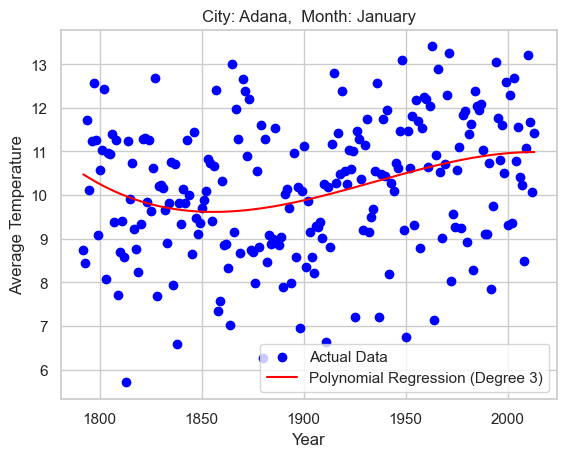

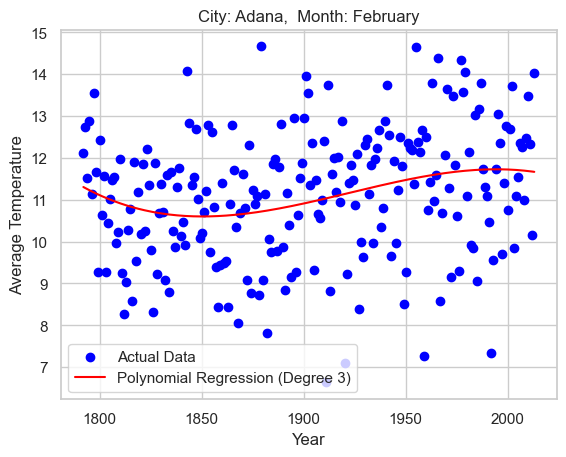

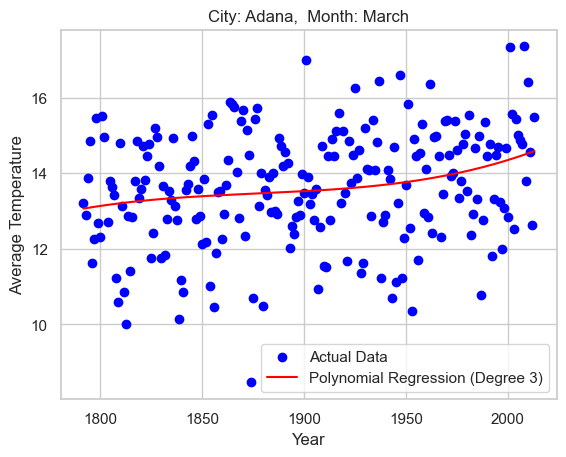

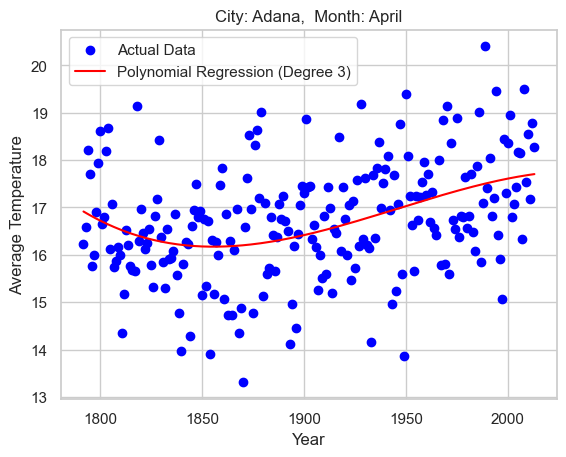

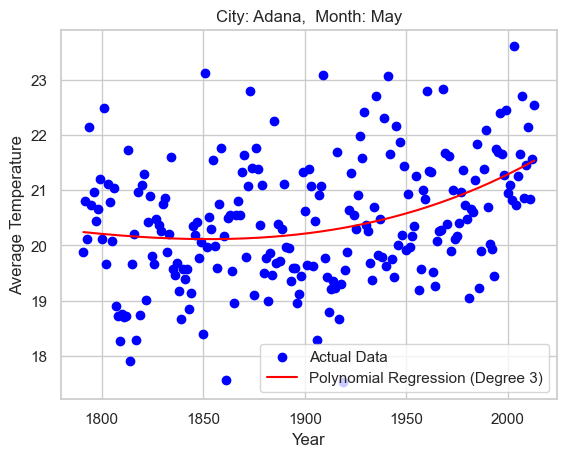

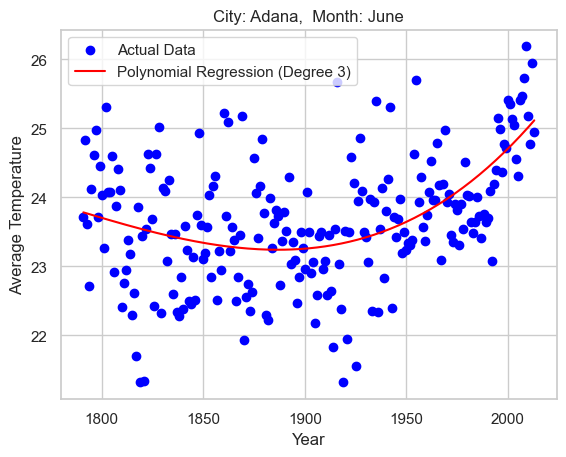

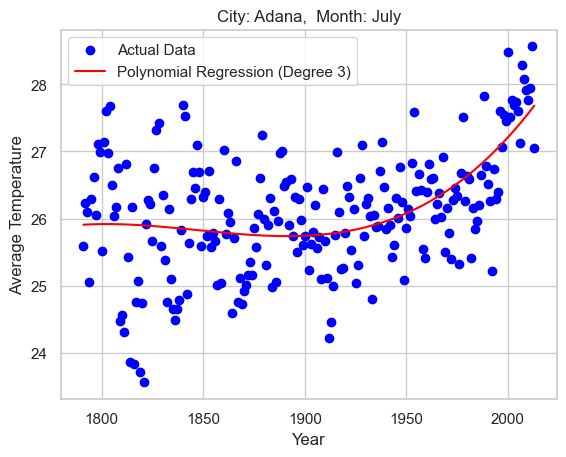

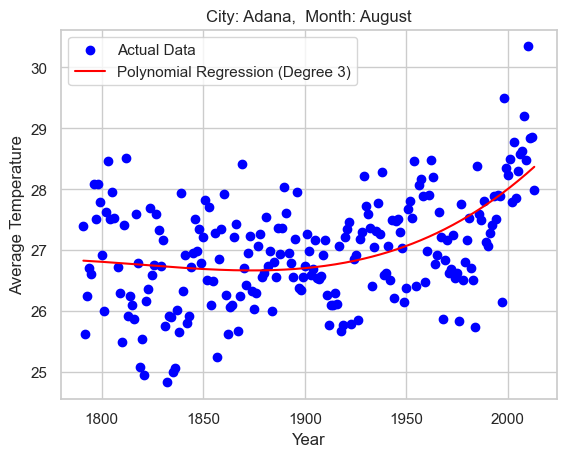

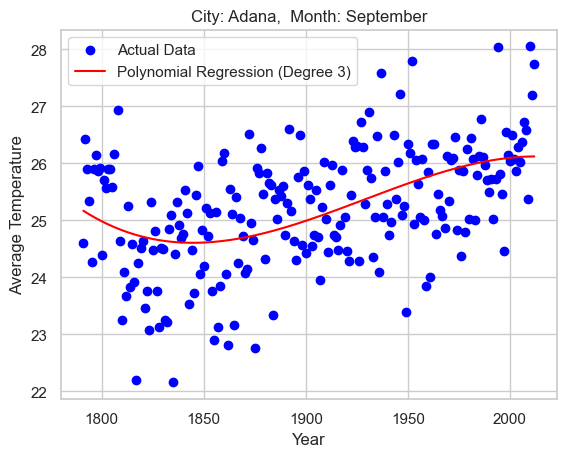

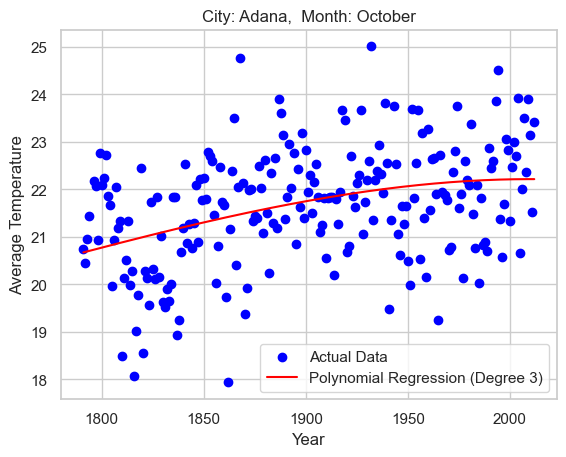

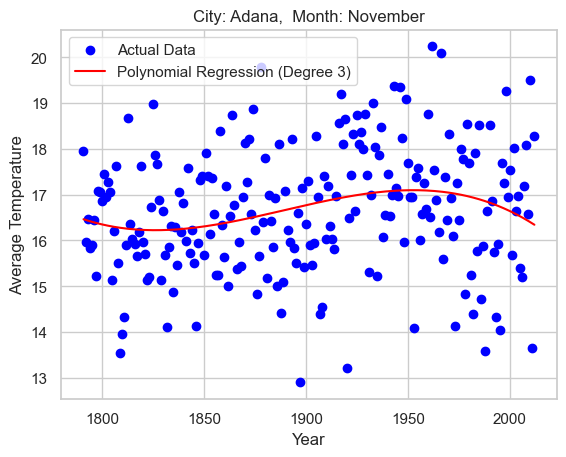

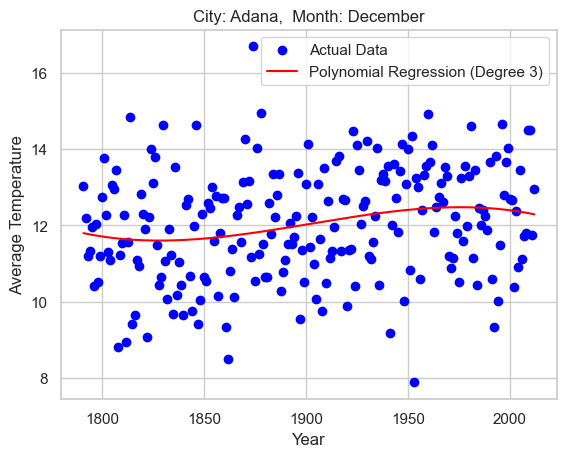

In [13]:
for i in range(1,13):    
    model = create_monthly_model(cities_montly_dict, "Adana", i)